In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import json
import plot_SNVM_data as pSd
from scipy.optimize import curve_fit

In [3]:
def exponential(t,A0,tau,t0,C):
    return A0*np.exp(-(t-t0)/tau)+C
def exponentialNot0(t,A0,tau,C):
    return A0*np.exp(-(t)/tau)+C
#def odrexp(B,t):
#    return B[0]*np.exp(-(t-B[2])/B[1])+B[3]
def odrexp(B,t):
    return B[0]*np.exp(-(t)/B[1])+B[2]
def twotopow(t,A0,tau,t0,C):
    return A0*np.power(2,(-(t-t0)/tau))+C
def tentopow(t,A0,tau,t0,C):
    return A0*np.power(10,(-(t-t0)/tau))+C
def fiftytopow(t,A0,tau,t0,C):
    return A0*np.power(50,(-(t-t0)/tau))+C
def logofexpNot0(t,A0,tau,C):
    return np.log(A0*np.exp(-(t)/tau)+C)
def logofexp(t,A0,tau,t0,C):
    return np.log(A0*np.exp(-(t-t0)/tau)+C)
def noCexp(t,A0,tau):
    return(A0*np.exp(-t/tau))
def gaussian_pdf(x,sigma,mu):
    return(1/(sigma*np.sqrt(2*np.pi))*np.exp((x-mu)**2/(2*sigma**2)))
def gaussian(x,x0,a,b):
    return(a*np.exp((x-x0)**2/(2*b**2)))
def poisson(x,lam,a,x0):
    return(a*np.power(lam,(x-x0))/scipy.special.factorial(x-x0)*np.exp(-lam))
def poissonNoFact(x,lam,a,x0):
    return(a*np.power(lam,(x-x0))*np.exp(-lam))

In [32]:
def read_and_save_T1_tevol(filepath, savetime_interval = 900, startindex_tevol_fit = 0):

    filelist = os.listdir(filepath)
    filepathlist = [os.path.join(filepath, filename) for filename in filelist]
    filepathlist.sort(key = os.path.getctime)

    files =[]
    for fileindex in range(1,len(filepathlist)):
        files.append(h5py.File(filepathlist[fileindex]))

    nrfiles = len(files)
    times = np.linspace(savetime_interval, nrfiles * savetime_interval, nrfiles)

    relaxations_timeresolv_delays = []
    relaxations_timeresolv_contrastms0s = []
    relaxations_timeresolv_ms0s = []
    relaxations_timeresolv_ref0s = []
    relaxation_timeresolv_T1s = []
    relaxation_timeresolv_T1_sigmas = []
    errors_single_relaxs = []
    popts = []
    pcovs = []

    for index in range(nrfiles):
        delay_temp = pSd.ExtractData(files[index], datatype = 'delay')[0][0]
        contrastms0_temp = pSd.ExtractData(files[index], datatype = 'contrastms0')[0][0]
        ms0_temp = pSd.ExtractData(files[index], datatype = 'ms0')[0][0]
        ref0_temp = pSd.ExtractData(files[index], datatype = 'ref0')[0][0]

        relaxations_timeresolv_delays.append(delay_temp)
        relaxations_timeresolv_contrastms0s.append(contrastms0_temp)
        relaxations_timeresolv_ms0s.append(ms0_temp)
        relaxations_timeresolv_ref0s.append(ref0_temp)

        error_temp = ms0_temp / ref0_temp * np.sqrt(1 / ms0_temp + 1 / ref0_temp)
        errors_single_relaxs.append(error_temp)

        # fit exponential decays
        popt_temp, pcov_temp = curve_fit(exponentialNot0, delay_temp, contrastms0_temp, sigma = error_temp, p0 = [0.2,1e-4,0])
        popts.append(popt_temp)
        pcovs.append(pcov_temp)

    # store taus
    for index in range(np.shape(popts)[0]):
        relaxation_timeresolv_T1s.append(popts[index][1])
        relaxation_timeresolv_T1_sigmas.append(np.sqrt(pcovs[index][1,1]))
        # print(np.shape(pcovs),pcovs[index])

    #fit time evolution
    popt_tevol, pcov_tevol = curve_fit(exponentialNot0, times[startindex_tevol_fit:], relaxation_timeresolv_T1s[startindex_tevol_fit:], 
                                    sigma = relaxation_timeresolv_T1_sigmas[startindex_tevol_fit:],
                                    p0 = [250*1e-6, 8*3600, 3000*1e-6])

    return times, relaxation_timeresolv_T1s, relaxation_timeresolv_T1_sigmas

[7.56568938e-05 2.24304409e+04 1.12110217e-04]
(82, 20)


Text(0, 0.5, '$T_1$ in µs')

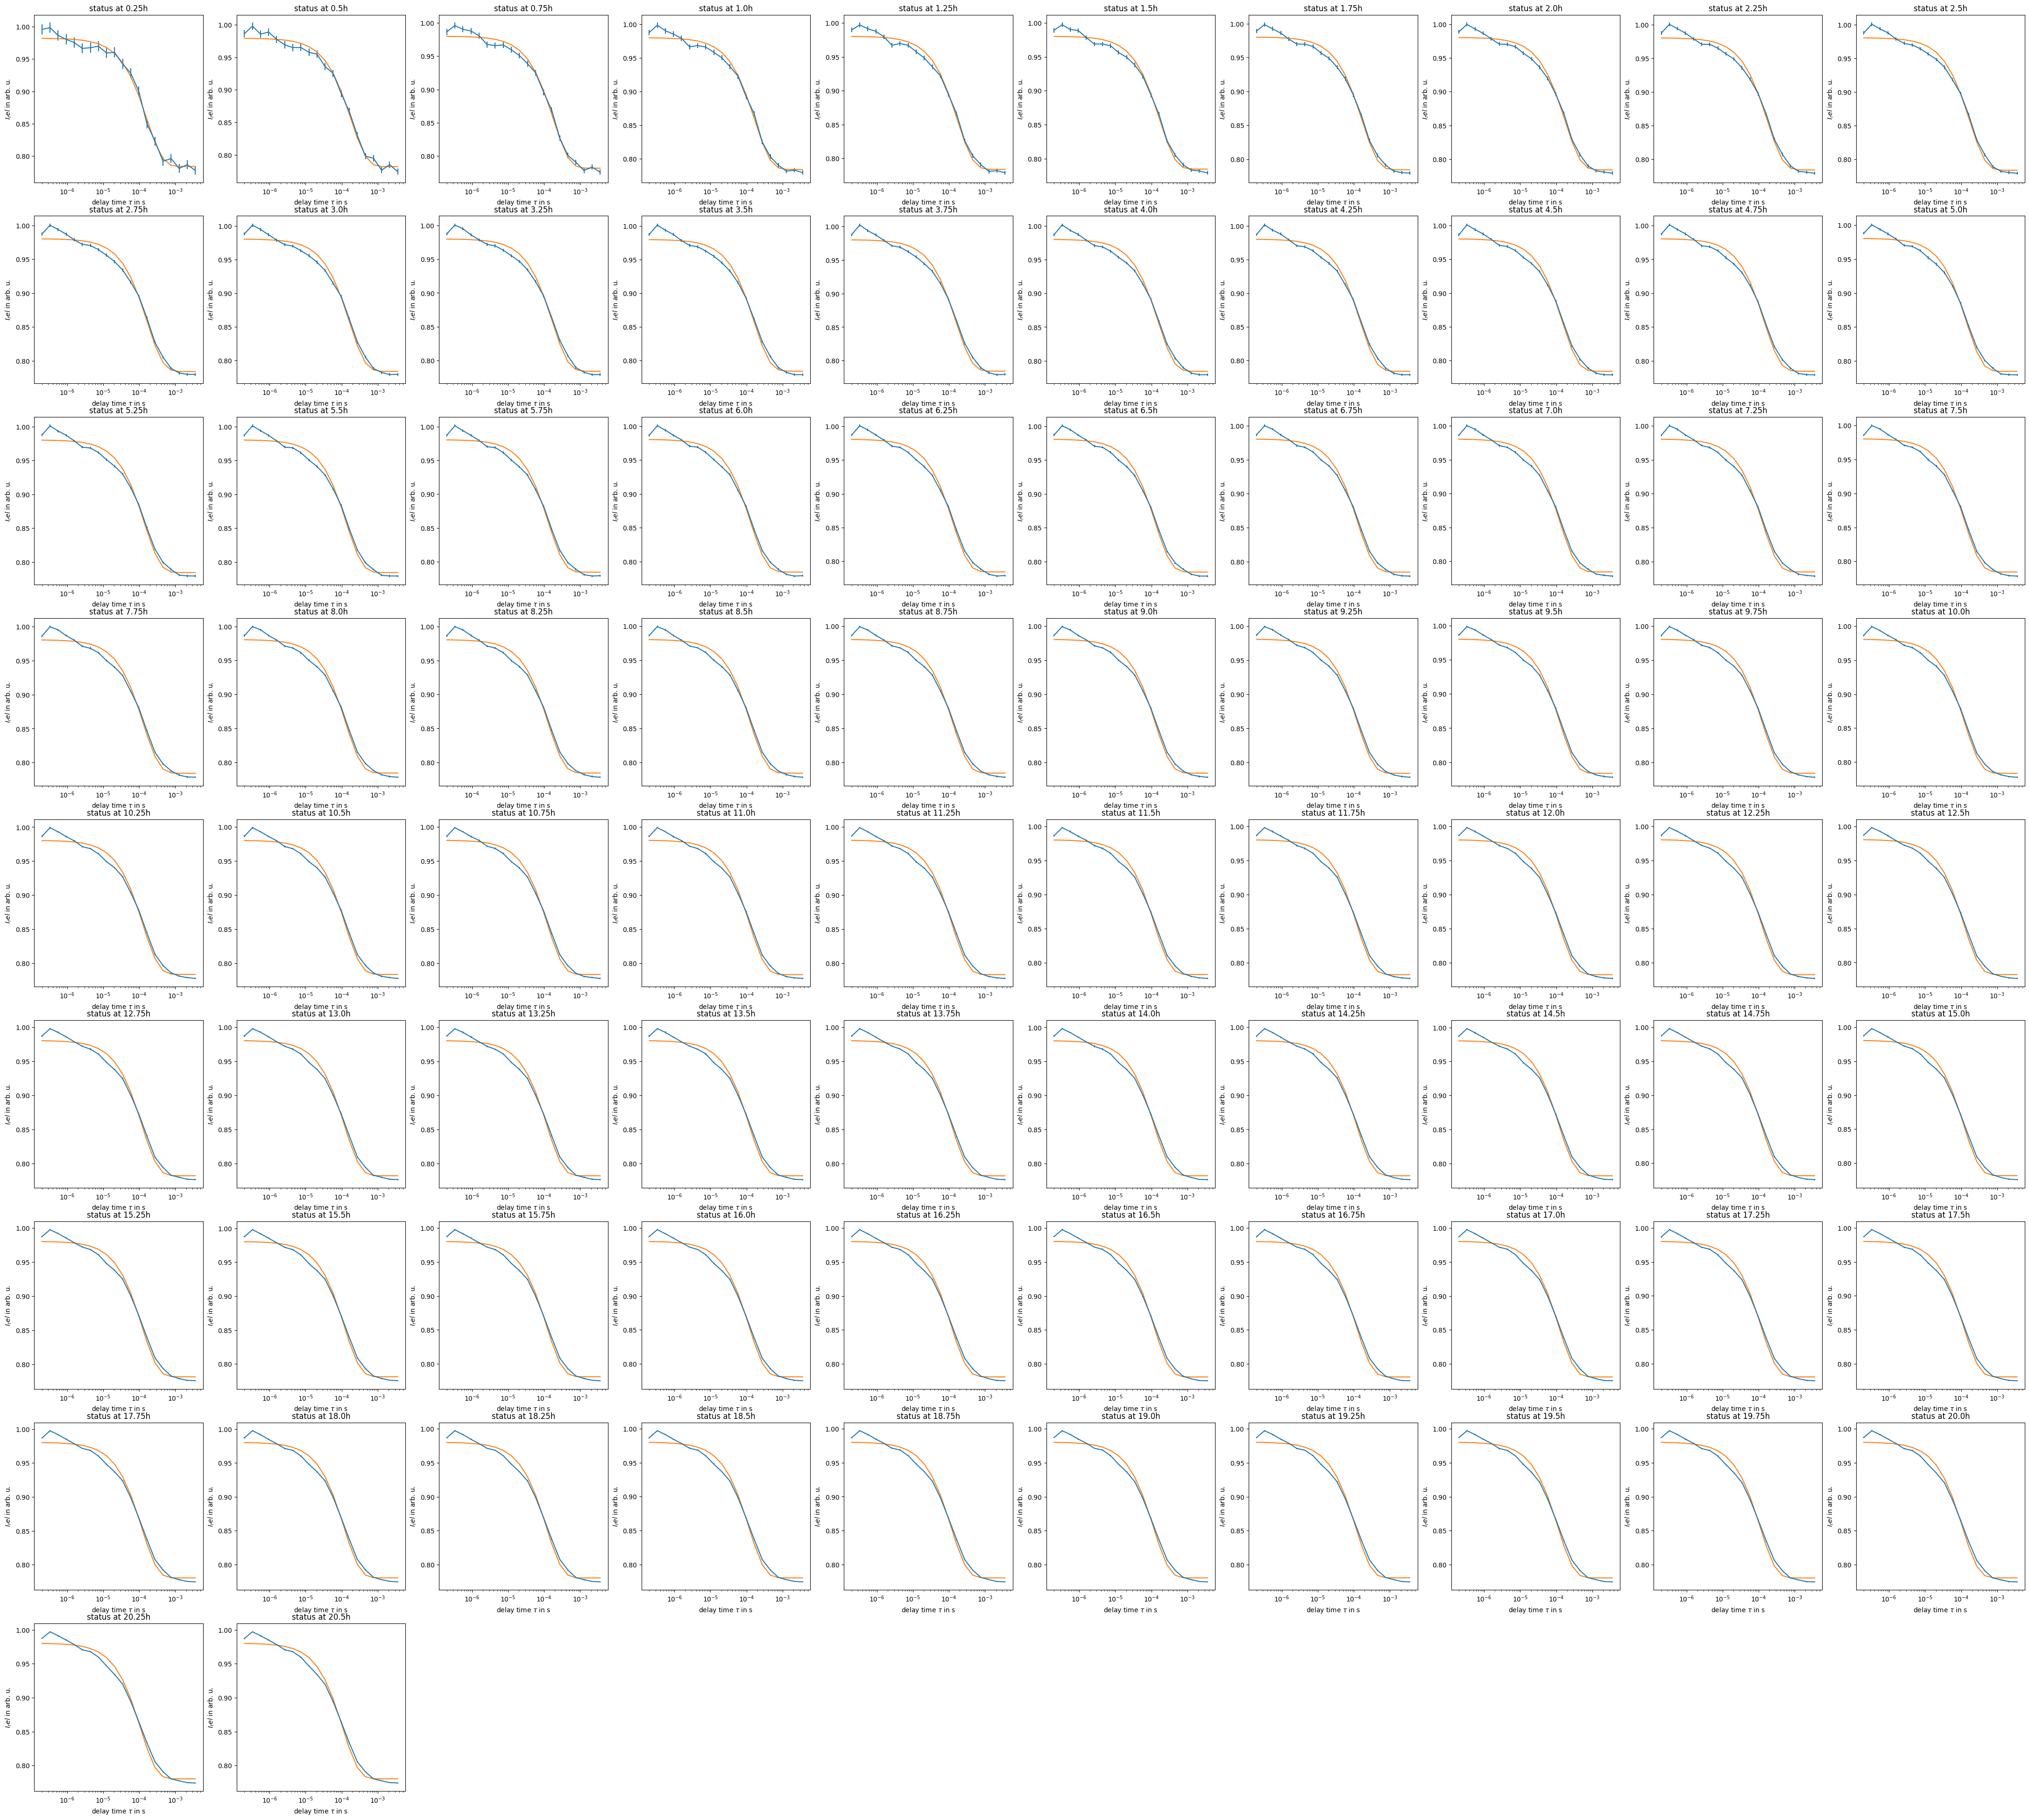

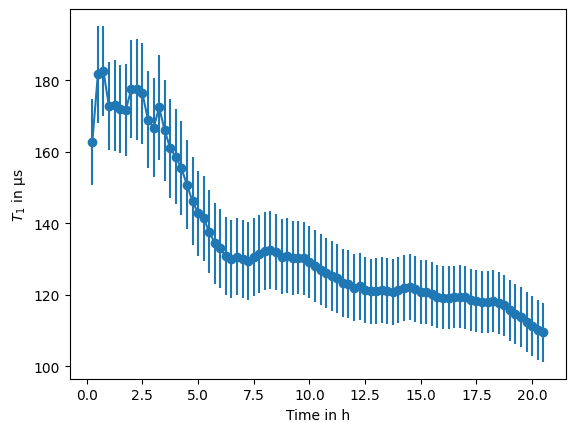

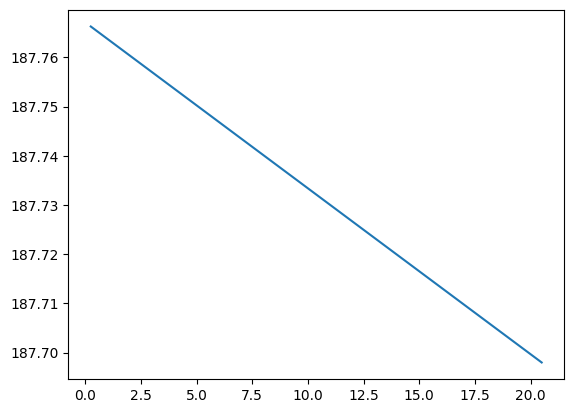

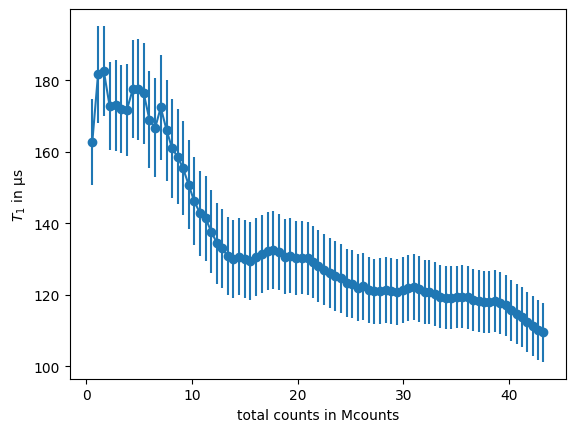

In [38]:
## read in all files in eval folder to get time dependent info
# filepath = r'W:\SNVM\QS3\Measurement Data\Pulse experiments\2024-11-12\relaxation_laser\2024-11-12-17-46-41-relaxation_laser\seq0\eval'
filepath = r'W:\SNVM\QS3\Measurement Data\Pulse experiments\2024-11-13\relaxation_laser\2024-11-13-17-15-15-relaxation_laser\seq0\eval'

filelist = os.listdir(filepath)
filepathlist = [os.path.join(filepath, filename) for filename in filelist]
filepathlist.sort(key = os.path.getctime)

files =[]
for fileindex in range(1,len(filepathlist)):
    files.append(h5py.File(filepathlist[fileindex]))


nrfiles = len(files)
savetime_interval = 900 ## in s
times = np.linspace(savetime_interval, nrfiles * savetime_interval, nrfiles)

relaxations_timeresolv_delays = []
relaxations_timeresolv_contrastms0s = []
relaxations_timeresolv_ms0s = []
relaxations_timeresolv_ref0s = []
relaxation_timeresolv_T1s = []
relaxation_timeresolv_T1_sigmas = []
errors_single_relaxs = []
popts = []
pcovs = []

for index in range(nrfiles):
    delay_temp = pSd.ExtractData(files[index], datatype = 'delay')[0][0]
    contrastms0_temp = pSd.ExtractData(files[index], datatype = 'contrastms0')[0][0]
    ms0_temp = pSd.ExtractData(files[index], datatype = 'ms0')[0][0]
    ref0_temp = pSd.ExtractData(files[index], datatype = 'ref0')[0][0]

    relaxations_timeresolv_delays.append(delay_temp)
    relaxations_timeresolv_contrastms0s.append(contrastms0_temp)
    relaxations_timeresolv_ms0s.append(ms0_temp)
    relaxations_timeresolv_ref0s.append(ref0_temp)

    error_temp = ms0_temp / ref0_temp * np.sqrt(1 / ms0_temp + 1 / ref0_temp)
    errors_single_relaxs.append(error_temp)

    # fit exponential decays
    popt_temp, pcov_temp = curve_fit(exponentialNot0, delay_temp, contrastms0_temp, sigma = error_temp, p0 = [0.2,1e-4,0])
    popts.append(popt_temp)
    pcovs.append(pcov_temp)

# store taus
for index in range(np.shape(popts)[0]):
    relaxation_timeresolv_T1s.append(popts[index][1])
    relaxation_timeresolv_T1_sigmas.append(np.sqrt(pcovs[index][1,1]))
    # print(np.shape(pcovs),pcovs[index])

#fit time evolution
startindex_tevol_fit = 0
popt_tevol, pcov_tevol = curve_fit(exponentialNot0, times[startindex_tevol_fit:], relaxation_timeresolv_T1s[startindex_tevol_fit:], 
                                   sigma = relaxation_timeresolv_T1_sigmas[startindex_tevol_fit:],
                                   p0 = [250*1e-6, 8*3600, 3000*1e-6])

print(popt_tevol)


### plotting ### 

## plot all measurements

fig = plt.figure(figsize=(5.5 * int(np.ceil(np.sqrt(nrfiles))), 5.5 * int(np.ceil(np.sqrt(nrfiles)))))
for i in range(nrfiles):
    ax_temp = fig.add_subplot(int(np.ceil(np.sqrt(nrfiles))),int(np.ceil(np.sqrt(nrfiles))),i+1)
    ax_temp.errorbar(relaxations_timeresolv_delays[i], relaxations_timeresolv_contrastms0s[i], yerr = errors_single_relaxs[i])
    ax_temp.plot(relaxations_timeresolv_delays[i], exponentialNot0(relaxations_timeresolv_delays[i], *popts[i]))
    ax_temp.set_xlabel(r'delay time $\tau$ in s')
    ax_temp.set_ylabel(r'$I_rel$ in arb. u.')
    ax_temp.set_xscale('log')
    ax_temp.set_title('status at ' + str(times[i]/3600) + 'h')


# plot time evolution of tau

fig_tauevol, ax_tauevol = plt.subplots()
ax_tauevol.errorbar(np.array(times[startindex_tevol_fit:])/3600, np.array(relaxation_timeresolv_T1s[startindex_tevol_fit:])*1e6, 
                    yerr = np.array(relaxation_timeresolv_T1_sigmas[startindex_tevol_fit:])*1e6, marker = 'o')
# ax_tauevol.plot(np.array(times[startindex_tevol_fit:])/3600, np.array(exponentialNot0(np.array(times[startindex_tevol_fit:])/3600, *popt_tevol))*1e6)
# ax_tauevol.set_xscale('log')
ax_tauevol.set_xlabel('Time in h')
ax_tauevol.set_ylabel(r'$T_1$ in µs')

fig_tauevol, ax_tauevol = plt.subplots()
ax_tauevol.plot(np.array(times[startindex_tevol_fit:])/3600, np.array(exponentialNot0(np.array(times[startindex_tevol_fit:])/3600, *popt_tevol))*1e6)

print(np.shape(relaxations_timeresolv_ms0s))

fig_T1_vs_counts, ax_T1_vs_counts = plt.subplots()
ax_T1_vs_counts.errorbar(np.sum(np.array(relaxations_timeresolv_ms0s[startindex_tevol_fit:]), axis=1)*1e-6, 
                      np.array(relaxation_timeresolv_T1s[startindex_tevol_fit:])*1e6,
                      yerr = np.array(relaxation_timeresolv_T1_sigmas[startindex_tevol_fit:])*1e6, marker = 'o')
ax_T1_vs_counts.set_xlabel('total counts in Mcounts')
ax_T1_vs_counts.set_ylabel(r'$T_1$ in µs')


#print(times)



In [ ]:
### combine two measurements in one plot #### deprecated

times_meas1, T1s_meas1, T1_sigmas_meas1 = read_and_save_T1_tevol(filepath1)
times_meas1 = np.array(times_meas1)
T1s_meas1 = np.array(T1s_meas1)
T1_sigmas_meas1 = np.array(T1_sigmas_meas1)

times_meas2, T1s_meas2, T1_sigmas_meas2 = read_and_save_T1_tevol(filepath2)
times_meas2 = np.array(times_meas2)
T1s_meas2 = np.array(T1s_meas2)
T1_sigmas_meas2 = np.array(T1_sigmas_meas2)

# times_combined = np.append(times_meas1,times_meas2 + times_meas1[-1])
# T1s_combined = np.append(T1s_meas1,T1s_meas2)
# T1_sigmas_combined = np.append(T1_sigmas_meas1,T1_sigmas_meas2)


#plot combined time evolution of T1
fig_T1s_combined, ax_T1s_combined = plt.subplots()
ax_T1s_combined.errorbar(times_meas1/3600, 
                      T1s_meas1*1e6,
                      yerr = T1_sigmas_meas1*1e6, marker = 'o', label = 'first T1 calibration measurement')
ax_T1s_combined.errorbar((times_meas2 + times_meas1[-1])/3600, 
                      T1s_meas2*1e6,
                      yerr = T1_sigmas_meas2*1e6, marker = 'o', label = 'second T1 calibration measurement')
ax_T1s_combined.set_xlabel('elapsed time in h')
ax_T1s_combined.set_ylabel(r'$T_1$ in µs')
ax_T1s_combined.legend()

length of all measurements appended after measurement number 1:  72


C:\Users\jskolaut\AppData\Local\Temp\ipykernel_23076\1806914620.py:35: RuntimeWarning: invalid value encountered in divide
  error_temp = ms0_temp / ref0_temp * np.sqrt(1 / ms0_temp + 1 / ref0_temp)
C:\Users\jskolaut\AppData\Local\Temp\ipykernel_23076\1806914620.py:35: RuntimeWarning: divide by zero encountered in divide
  error_temp = ms0_temp / ref0_temp * np.sqrt(1 / ms0_temp + 1 / ref0_temp)


OSError: [Errno 22] Can't synchronously read data (file read failed: time = Thu Nov 14 21:21:50 2024
, filename = 'W:\SNVM\QS3\Measurement Data\Pulse experiments\2024-11-13\relaxation_laser\2024-11-13-17-15-15-relaxation_laser\seq0\eval\relaxation_0_0_5400.0s.h5', file descriptor = 8, errno = 22, error message = 'Invalid argument', buf = 000002F04CAA1A28, total read size = 480, bytes this sub-read = 480, bytes actually read = 18446744073709551615, offset = 2048)

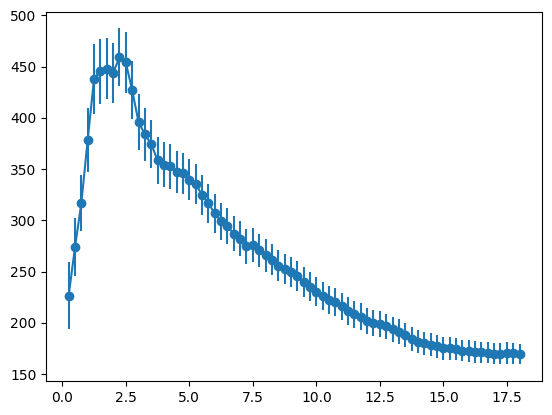

: 

In [ ]:
## combine all measurements in filepaths into one sequential plot

filepaths = [r'W:\SNVM\QS3\Measurement Data\Pulse experiments\2024-11-12\relaxation_laser\2024-11-12-17-46-41-relaxation_laser\seq0\eval', 
             r'W:\SNVM\QS3\Measurement Data\Pulse experiments\2024-11-13\relaxation_laser\2024-11-13-17-15-15-relaxation_laser\seq0\eval',
             r'W:\SNVM\QS3\Measurement Data\Pulse experiments\2024-11-14\relaxation_laser\2024-11-14-14-29-33-relaxation_laser\seq0\eval',
             r'W:\SNVM\QS3\Measurement Data\Pulse experiments\2024-11-14\relaxation_laser\2024-11-14-16-59-20-relaxation_laser\seq0\eval']

times_all_meas = []
T1s_all_meas = []
T1_sigmas_all_meas = []

fig_all_meas, ax_all_meas = plt.subplots()

last_time = 0
for [index,filepath] in enumerate(filepaths):
    times_temp, T1s_temp, T1_sigmas_temp = read_and_save_T1_tevol(filepath)
    
    times_temp = np.array(times_temp)
    T1s_temp = np.array(T1s_temp)
    T1_sigmas_temp = np.array(T1_sigmas_temp)
    
    times_all_meas = np.append(times_all_meas, times_temp)
    T1s_all_meas = np.append(T1s_all_meas, T1s_temp)
    T1_sigmas_all_meas = np.append(T1_sigmas_all_meas, T1_sigmas_temp)

    print('length of all measurements appended after measurement number ' + str(index+1) + ': ', np.shape(times_all_meas)[0])

    # plotting
    
    ax_all_meas.errorbar((times_temp + last_time)/3600, T1s_temp*1e6, yerr = T1_sigmas_temp*1e6, 
                         marker = 'o', label = r'$T_1$ calibration ' + str(index+1) )
    last_time = times_temp[-1] + last_time
    
ax_all_meas.set_xlabel('elapsed time in h')
ax_all_meas.set_ylabel(r'$T_1$ in µs')
ax_all_meas.legend()


#fit time evolution
# startindex_tevol_fit = 0
# popt_tevol, pcov_tevol = curve_fit(exponentialNot0, times[startindex_tevol_fit:], relaxation_timeresolv_T1s[startindex_tevol_fit:], 
#                                    sigma = relaxation_timeresolv_T1_sigmas[startindex_tevol_fit:],
#                                    p0 = [250*1e-6, 8*3600, 3000*1e-6])

# print(popt_tevol)


